# Ordinal Encoding with Titanic

In this notebook, we implement ordinal encoding to the column "Cabin" in the Titanic dataset. The column has been initially "engineered" so that only the first letter remains. Then, the order of the categories is manually defined, alphabetically, from "A" to "T", and ultimatelly with "N_A" (the replacement for null values).

With this choice of preprocessing, we achieve a more compact dataset (fewer columns created with one-hot encoding), although our pipeline gets more complex: the categorical branch will contain now the SimpleImputer, followed by a ColumnTransformer that branches into One Hot and Ordinal encoding. 

## 1. Reading, cleaning & splitting

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn import set_config

# reading
url = "https://drive.google.com/file/d/1g3uhw_y3tboRm2eYDPfUzXXsw8IOYDCy/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = df = pd.read_csv(path)

# X and y creation
X = data.drop(columns=["PassengerId", "Name", "Ticket"])
y = X.pop("Survived")

# Feature Engineering
X.loc[:, "Cabin"] = X.Cabin.str[0]

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Exploring the cabin column to understand ordinal encoding
First, let's make a DataFrame of only the column `Cabin`

In [4]:
X_ordinal = pd.DataFrame(X.loc[:, "Cabin"])
X_ordinal.head(10)

,Cabin
0,NaN
1,C
2,NaN
3,C
4,NaN
5,NaN
6,E
7,NaN
8,NaN
9,NaN


Now, as always, we need to impute the missing values. We will use the string "N_A" for missing values, this way we can give missing values a category of their own.

In [5]:
X_ordinal_imputed = SimpleImputer(strategy="constant", fill_value="N_A").fit_transform(X_ordinal)
pd.DataFrame(X_ordinal_imputed).head(10)

,0
0,N_A
1,C
2,N_A
3,C
4,N_A
5,N_A
6,E
7,N_A
8,N_A
9,N_A


Next, let's use the ordinal encoder to transform our one column and see what effect it has.

In [6]:
X_ordinal_imputed_ord = OrdinalEncoder().fit_transform(X_ordinal_imputed)
pd.DataFrame(X_ordinal_imputed_ord).head(10)

,0
0,7.0
1,2.0
2,7.0
3,2.0
4,7.0
5,7.0
6,4.0
7,7.0
8,7.0
9,7.0


Fantastic, it converted our categorical data to numerical data. But what do these numbers represent? Let's make a quick dummy DataFrame with each of the letters from `Cabin` and see how it converts them.

In [7]:
test_df = pd.DataFrame({"cabin_letter": ["A", "B", "C", "D", "E", "F", "G", "T", "N_A"]})
test_df

,cabin_letter
0,A
1,B
2,C
3,D
4,E
5,F
6,G
7,T
8,N_A


In [8]:
test_df_transformed = OrdinalEncoder().fit_transform(test_df)
test_df_transformed

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [8.],
       [7.]])

Interesting! It converts them all in order except for `T` and `N_A`, why is that? Looking at it, it must be making assumptions about our data and coding everything alphabetically, this doesn't work for our data, we want a strict order, where `N_A` comes after `T`.

Think about it, if we were ordinal encoding `good` and `bad`, then alphabetical order is fine. However, if we had wanted to ordinal encode the values `very bad`, `bad`, `okay`, `good`, `very good`, then the alphabetical order would be `bad`, `good`, `okay`, `very bad`, `very good`. This makes no sense and would only serve to confuse our model. The point of ordinal encoding is to give an order to the categories, to ensure that our model does what we would like, and doesn't just go around guessing, we need to be explicit and create a list of the categories in the order we would like them to be considered.

In [9]:
cabin_cats = ["A", "B", "C", "D", "E", "F", "G", "T", "N_A"]

test_df_transformed_2 = OrdinalEncoder(categories=[cabin_cats]).fit_transform(test_df)
test_df_transformed_2

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
       [8.]])

## 2. Building the `preprocessor`

We have included all the code to create the preprocessing pipeline in a single cell for compactness. Take your time to understand what's going on. If needed, create multiple cells and bring the code there step by step, analyzing the output each time. Writing a sketch of the pipeline with pen an paper is also a good idea.

A common error is trying to use a ColumnTransformer after the column names have been lost in a previous pipeline step (in our case, the SimpleImputer). This can be solved either using a pandas method instead of a sklearn transformer (e.g. `df.fill_na`), wrapped in a FunctionTransformer, or by passing the indices instead of the column names to the ColumnTransformer, as we show here.

In [26]:
# 0. Set the config so that we can view our preprocessor
set_config(display="diagram")

# 1. defining categorical & ordinal columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 2. numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

# 3. categorical pipeline

# # 3.1 defining ordinal & onehot columns
# .get_indexer() get's the index to solve the problem described above about losing column names
ordinal_cols = X_cat.columns.get_indexer(["Cabin"])
onehot_cols = X_cat.columns.get_indexer(["Sex", "Embarked"])

# # 3.2. defining the categorical encoder

# # # 3.2.1. we manually establish the order of the categories for our ordinal feature (Cabin), including "N_A"
cabin_cats = ["A", "B", "C", "D", "E", "F", "G", "T", "N_A"]

# # # 3.2.2. defining the categorical encoder: a ColumnTransformer with 2 branches: ordinal & onehot
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(categories=[cabin_cats]), ordinal_cols),
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols),
    ]
)

# # 3.3. categorical pipeline = "N_A" imputer + categorical encoder
categorical_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="N_A"),
                                 categorical_encoder
                                )

# 4. full preprocessing: a ColumnTransformer with 2 branches: numeric & categorical
full_preprocessing = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categorical_pipe, X_cat.columns),
    ]
)

full_preprocessing

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                ('cat_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N_A',
                                                                strategy='constant')),
                                                 ('columntransformer',
                                                  ColumnTransformer(transformers=[('cat_ordinal',
                                                                                   OrdinalEncoder(categories=[['A',
                                                                                                               'B',
                                                                                                               'C',
                                                                                                               'D',
                                                                                                               'E',
                                                                                                               'F',
                                                                                                               'G',
                                                                                                               'T',
                                                                                                               'N_A']]),
                                                                                   array([1])),
                                                                                  ('cat_onehot',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   array([0, 2]))]))]),
                                 Index(['Sex', 'Cabin', 'Embarked'], dtype='object'))])

## 3. Decision Tree

In [27]:
from sklearn.model_selection import GridSearchCV

# full pipeline: preprocessor + model
full_pipeline = make_pipeline(full_preprocessing, 
                              DecisionTreeClassifier())

# define parameter grid
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}

# define GridSearchCV
search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='N_A',
                                                                                                        strategy='constant')),
                                                                                         ('columntransformer',
                                                                                          ColumnT...
                                                                                                                           OneHotEncoder(handle_unknown='ignore'),
                                                                                                                           array([0, 2]))]))]),
                                                                         Index(['Sex', 'Cabin', 'Embarked'], dtype='object'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'decisiontreeclassifier__max_depth': range(2, 14, 2),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 12, 2)},
             verbose=1)

In [28]:
search.fit(X_train, y_train)
 
print(f"The best average score in cross validation was {search.best_score_}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
The best average score in cross validation was 0.8033586132177681


## 4. Error analysis

In [29]:
accuracy_score(search.predict(X_test), y_test)

0.8435754189944135

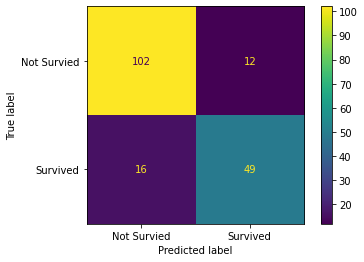

In [30]:
# For older versions of SKLearn use plot_confusion_matrix
# DEPRECATED: Function plot_confusion_matrix is deprecated in 1.0 and will be removed in 1.2.
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(search, X_test, y_test, display_labels=['Not Survied', 'Survived']);

# plot conversion matrix in newer versions of SKLearn
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(search, 
                                      X_test, 
                                      y_test, 
                                      display_labels=['Not Survied', 'Survived']);

## 5. An example of how to ordinal encode multiple columns

In [ ]:
ordinal_columns = X_cat.columns.get_indexer(["LotShape", "Utilities", "LandSlope"])

LotShape_cats = ["Reg", "IR1", "IR2", "IR3"]
Utilities_cats = ["AllPub", "NoSewr", "NoSeWa", "ELO"]
LandSlope_cats = ["Gtl", "Mod", "Sev"]

ordinal_cats = [LotShape_cats, Utilities_cats, LandSlope_cats]

OrdinalEncoder(categories = ordinal_cats)

## **Your challenge**

In a new notebook, apply everything you have learned here to the Housing project, following the Learning platform.